# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

/home/yannik/yenv2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yannik/yenv2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Define the objective and problem

In [2]:
# first type of objective
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                             grad=sp.optimize.rosen_der, 
                             hess=sp.optimize.rosen_hess)

# second type of objective
def rosen2(x):
    return sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x)
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

lb = -2 * np.ones((100,1))
ub = 2 * np.ones((100,1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

## Illustration

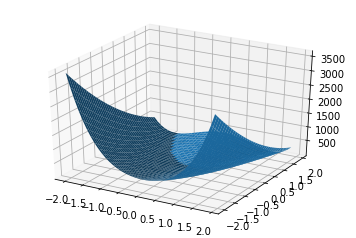

In [3]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)        

## Run optimization

In [4]:
optimizer = pypesto.ScipyOptimizer()
                                                                                                                                                                                                                                                                                                                                                                
result1 = pypesto.minimize(problem=problem1, optimizer=optimizer, n_starts=20)
result2 = pypesto.minimize(problem=problem2, optimizer=optimizer, n_starts=20)

/home/yannik/yenv2/lib/python3.6/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/home/yannik/yenv2/lib/python3.6/site-packages/scipy/optimize/_minimize.py:513: RuntimeWarning: Method L-BFGS-B does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)


## Visualize and analyze results

pypesto offers easy-to-use visualization routines:

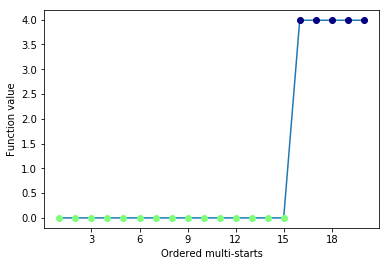

In [5]:
import pypesto.visualize

pypesto.visualize.waterfall(result1)

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [6]:
result1.optimize_result.as_dataframe(['fval', 'n_fval', 'time'])

,fval,n_fval,time
0,8.599771e-11,595,0.337839
1,8.941647e-11,613,0.073811
2,1.026964e-10,608,0.274253
3,1.365516e-10,581,0.325124
4,1.424408e-10,621,0.075743
5,1.525355e-10,591,0.324534
6,1.552232e-10,611,0.201776
7,1.573482e-10,597,0.257375
8,1.599282e-10,621,0.155936
9,2.320528e-10,589,0.210692
